# Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


import sys
import os
from os import listdir
from os.path import isfile, isdir, join
pd.set_option('display.max_rows', 500)

import math
import umap
from sklearn.cluster import DBSCAN
import scipy.stats
import scipy.optimize as opt

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import PandasTools
# import xlsxwriter

from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors
from rdkit.Chem.rdDepictor import Compute2DCoords
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.MolStandardize import rdMolStandardize
import mols2grid

# import requests
# lib_file = requests.get("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/sar_analysis/scaffold_finder.py")
# ofs = open("scaffold_finder.py","w")
# print(lib_file.text,file=ofs)
# ofs.close()
from scaffold_finder import generate_fragments, find_scaffolds, get_molecules_with_scaffold, cleanup_fragment
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score

import datamol as dm
from sort_and_slice_ecfp_featuriser import create_sort_and_slice_ecfp_featuriser
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import pairwise_distances
import brewer2mpl
from sklearn.datasets import make_blobs
import colorcet as cc
from SAR_utils import *

# Import & Processing

[15:17:23] Running LargestFragmentChooser
[15:17:23] Running Uncharger
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running Uncharger
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running Uncharger
[15:17:23] Running LargestFragmentChooser
[15:17:23] Fragment: O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O
[15:17:23] New largest fragment: O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O (42)
[15:17:23] Fragment: Cl
[15:17:23] Fragment: O
[15:17:23] Running Uncharger
[15:17:23] Running LargestFragmentChooser
[15:17:23] Fragment: N[C@@H]1[C@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)C[C@@H]12
[15:17:23] New largest fragment: N[C@@H]1[C@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)C[C@@H]12 (45)
[15:17:23] Fragment: CS(=O)(=O)O
[15:17:23] Running Uncharger
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running Uncharger
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running Uncharger
[15:17:23] Running LargestFragmentChooser
[15:17:23] Running Uncharger
[15:17:2

,Compound name,IC50,Stdev,Mean_Rsq,Ns,Bestfit_IC50,Bestfit_IC50_stdev,Bestfit_IC50_CL,LD50<60.0uM,SMILES,Type,Structure,IC50 Ranges,UMAP_X,UMAP_Y,tSNE_X,tSNE_Y,ECFP_Cluster,Clean_SMILES
0,Grepafloxacin,2.56,2.333452,0.73,4,0.91,0.01,MLT069,True,Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1,AB,,0-5,10.942218,14.275463,-2.840783,8.921162,12,Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1

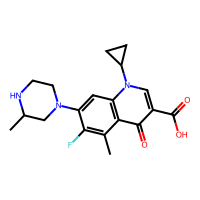

In [2]:
SAR_df = pd.read_excel(r'Results/JJ/updated/Fib_SAR_df.xlsx',index_col=0) # Use Fibulin data only
SAR_df = SAR_df[SAR_df['Type']=='AB'] # Only find common scaffold on FQs (antibiotics) and remove N23Ps
# Remove any salts or solvents from the SMILES
SAR_df["Clean_SMILES"] = SAR_df["SMILES"].apply(remove_salts)
SAR_df["SMILES"] = SAR_df["Clean_SMILES"]
# Generate SMILES-based images 
PandasTools.AddMoleculeColumnToFrame(SAR_df,"SMILES","Structure","Type")
PandasTools.RenderImagesInAllDataFrames(images=True)
SAR_df.head(1)

In [3]:
# calculate pIC50
SAR_df['pIC50'] = -np.log10(SAR_df['IC50'])
# filtering
preprocessed_df = SAR_df[["SMILES","Compound name","pIC50","ECFP_Cluster"]]
preprocessed_df.columns = ["SMILES","Name","pIC50","Cluster"]
preprocessed_df['mol'] = preprocessed_df.SMILES.apply(Chem.MolFromSmiles)
preprocessed_df = preprocessed_df.dropna(subset=['pIC50'])

generates and summarizes molecular scaffolds from input 51 FQ molecules by fragmenting each structure, collecting all resulting scaffolds, and returning both the molecule–fragment mappings and a ranked list of unique scaffolds by frequency and size.

In [4]:
mol_df,scaffold_df = find_scaffolds(preprocessed_df)

  0%|          | 0/51 [00:00<?, ?it/s]

iterates through each structural cluster, identify scaffolds within that cluster, and collects the most representative scaffold from each cluster

In [5]:
all_scaffolds = pd.DataFrame()
preprocessed_df = preprocessed_df.sort_values(by="Cluster")

for cl in preprocessed_df["Cluster"].unique():
    preprocessed_df_inloop = preprocessed_df[preprocessed_df["Cluster"]==cl]
    mol_df,scaffold_df = find_scaffolds(preprocessed_df_inloop) # find scaffolds within each cluster
    # assign each scaffold with its cluster index
    scaffold_df["Cluster"] = cl
#     take the first scaffold from each cluster as a representative
    if cl ==1:
#         scaffold_listing =scaffold_df[scaffold_df["cluster"] ]
        all_scaffolds = scaffold_df.head(1)
    else:
        all_scaffolds = pd.concat([all_scaffolds ,scaffold_df.head(1)],ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

visualizes the representative scaffold from each cluster

Here only 18 representitives are displayed. No.14 is missing, which is N23Ps


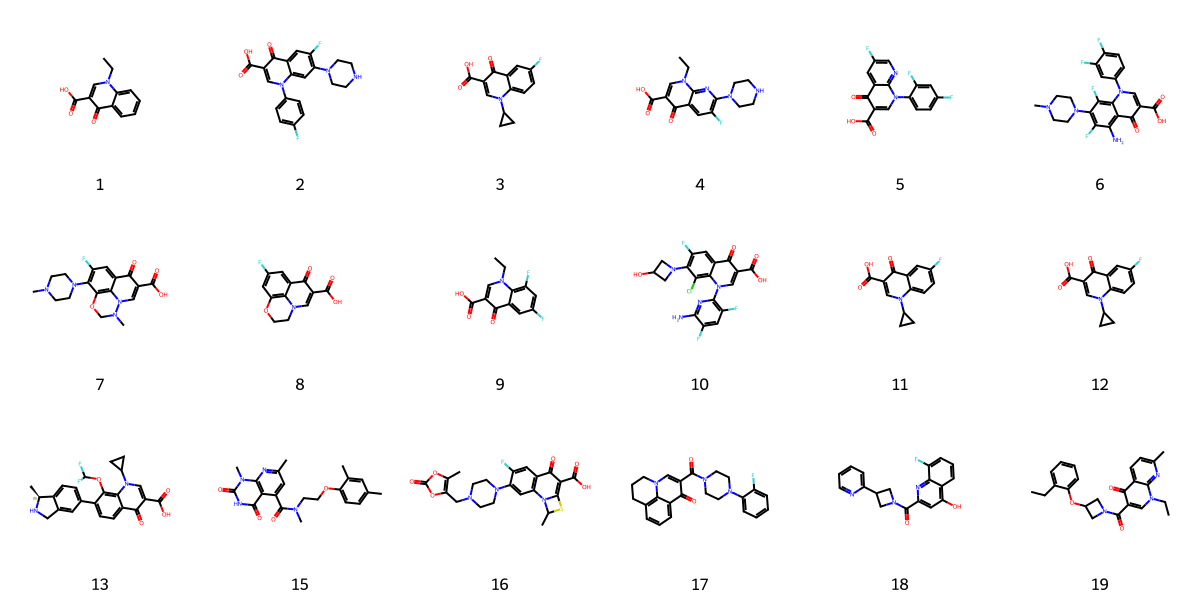

In [6]:
legends =all_scaffolds["Cluster"].astype(str).to_list()
dm.viz.to_image(all_scaffolds["Scaffold"],legends=legends, n_cols=6, mol_size=(200, 200)) # display all scaffolds from each cluster

So the next steps are to find the (max?) common scaffolds and identify

In [7]:
# Dictionary of cluster groups
cluster_groups = {1: (1, 9), # 
                  2: (3, 11, 12), # 
                  3: (2, 6), # 
                  4: (5, 19), # 
                  5: (7, 8)
                  # 
                  }
 #Clusters not used 
clusters_wo_groups = [4, 10, 13, 15, 16, 17, 18] #10 molecules in total

## Group PLSR

  0%|          | 0/7 [00:00<?, ?it/s]

'7>>>>>>>7'

  0%|          | 0/7 [00:00<?, ?it/s]

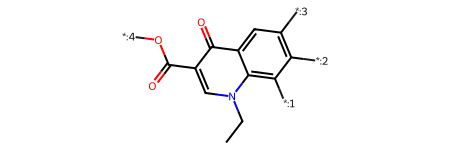

[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:36] WARNING: not removing hydrogen atom with dummy atom neighbors


  0%|          | 0/16 [00:00<?, ?it/s]

[15:18:36] No core matches


'16>>>>>>>15'

  0%|          | 0/15 [00:00<?, ?it/s]

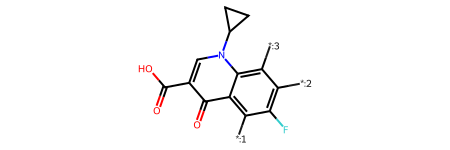

[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with

  0%|          | 0/4 [00:00<?, ?it/s]

'4>>>>>>>4'

  0%|          | 0/4 [00:00<?, ?it/s]

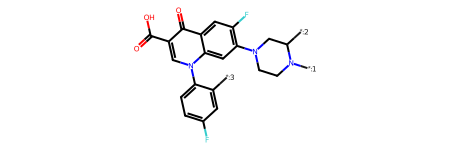

[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:18:37] WARNING: not removing hydrogen atom with

  0%|          | 0/4 [00:00<?, ?it/s]

[15:18:37] No core matches
[15:18:37] No core matches


'4>>>>>>>2'

  0%|          | 0/2 [00:00<?, ?it/s]

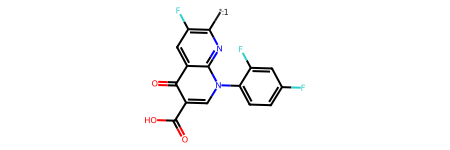

  0%|          | 0/9 [00:00<?, ?it/s]

[15:18:38] No core matches
[15:18:38] No core matches
[15:18:38] No core matches
[15:18:38] No core matches


'9>>>>>>>5'

  0%|          | 0/5 [00:00<?, ?it/s]

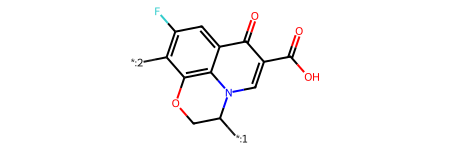

In [10]:
# 1. Initialize empty collectors for:
final_output_main = pd.DataFrame() # per cluster RGD results
coefficients_df = pd.DataFrame() # PLSR feature coefficients
failed_df_main = pd.DataFrame() # failure records with reasons
keys_to_iterate = [1, 2, 3, 4, 5]
cols_for_lookup = ['Compound name', 'SMILES', 'Name', 'pIC50', 'Cluster', 'mol']
used_scaffolds_all = set()

_pre = preprocessed_df.copy()
# Ensure a 'Compound name' key for merging later
if "Compound name" not in _pre.columns:
    _pre["Compound name"] = _pre["Name"]

# Keep only the columns that exist
pre_lookup = _pre[[c for c in cols_for_lookup if c in _pre.columns]].drop_duplicates("Compound name")

# 2. Loop through each key
for key in keys_to_iterate:
    cl = cluster_groups.get(key) # In the dictionary, get the value corresponding to the key
    if cl is not None:
        '''
        final_output:per-molecule table (has R-group columns 'R1_SMILES',...)
        R_length: number of R positions
        clean_scaffold_mol/preclean_scaffold: scaffold info
        failed_df: molecules that already failed inside 'Cluster_PLSR'
        '''
        final_output,R_length, clean_scaffold_mol,preclean_scaffold,failed_df,used_scaffold = Cluster_PLSR(cl, preprocessed_df, SAR_df)
        # Collect displayed scaffolds
        if used_scaffold is not None:
            used_scaffolds_all.add(used_scaffold)
       
        # PLSR
        # Make the list of R-group columns wil be one-hot encoded
        R_smiles = [f"R{i}_SMILES" for i in range(1, (R_length + 1))]
        R_arr = np.array([])
        R_names = np.array([])
        for R_smile in R_smiles:
            R_arr = np.append(R_arr, final_output[R_smile].unique()) # for each R position: collect all uniquesubstituent strings at that position
            uniq_res = final_output[R_smile].unique()
            uniq_res = [f"{name}_{R_smile}" for name in uniq_res] # build feature names: concat substituent + position ('C1_R1_SMILES')
            R_names = np.append(R_names, uniq_res) # append to R_names

        # Prepend two cols to the feature list: compound identifier and the response variable
        R_names = np.append(["Compound name", "Activity"], R_names) 
        features_df = pd.DataFrame(0, index=range(len(final_output)), columns=R_names) # create a df filled with 0 for one-hot features
        
        # One hot encoding
        for i in range(len(final_output)):
            loop_df = final_output.iloc[[i]]
            for RG in R_smiles:
                stringed_val = loop_df[f"{RG}"].iloc[0]
                for col in features_df.columns:
                    if f"{stringed_val}_{RG}" == col:
                        features_df.at[i, col] = 1
        
        features_df["Compound name"] = final_output["Compound name"]
        # Activity = IC50
        features_df["Activity"] = final_output["IC50"] 
        features_df = features_df[features_df["Compound name"].notna()]
        # features_df['Activity'] = features_df['Activity'].apply(lambda x: min(x, 100)) # cap IC50 at 100 to limit extreme values
        

        # Assuming the last column is IC50 and the rest are features
        ######### Split predictors (X: all one-hot columns) and (y:'Activity' = IC50)
        X = features_df.iloc[:, 2:]  # Features
        y = features_df.iloc[:, 1]   # IC50 values

        # Convert to numeric and handle NaN
        X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0) # replace feature NaNs with 0
        y = pd.to_numeric(y, errors="coerce") # make invalid y to NaN

        # Keep names for failure recording
        _names = features_df["Compound name"].astype(str).values

        # 1) Per-compound failure: missing Activity
        _mask_bad_y = y.isna()
        if _mask_bad_y.any():
            new_fail = pd.DataFrame({
            "Compound name": _names[_mask_bad_y.values],
            "Key": key,
            "Reason": "Missing Activity"
            })
            # Back-fill structure columns
            new_fail = new_fail.merge(pre_lookup, on="Compound name", how="left")
            # Ensure consistent column order
            col_order = ["SMILES","Name","pIC50","Cluster","mol","Compound name","Key","Reason"]
            new_fail = new_fail[[c for c in col_order if c in new_fail.columns]]

            failed_df_main = pd.concat([failed_df_main, new_fail], ignore_index=True)


        # Remove those rows from modeling
        X = X.loc[~_mask_bad_y].copy()
        y = y.loc[~_mask_bad_y].copy()
        _names = _names[~_mask_bad_y.values]

        # Remove all-zero columns (uninformative)
        if X.shape[1] > 0:
            X = X.loc[:, (X != 0).any(axis=0)]

        # 2) Per-compound failure: drop features never present (all-zero after one-hot)
        if X.shape[0] > 0 and X.shape[1] > 0:
            _row_all_zero = (X.sum(axis=1) == 0)
            if _row_all_zero.any():
                new_fail = pd.DataFrame({
                    "Compound name": _names[_row_all_zero.values],
                    "Key": key,
                    "Reason": "No informative R-group features (row all-zero)"
                })
                new_fail = new_fail.merge(pre_lookup, on="Compound name", how="left")
                col_order = ["SMILES","Name","pIC50","Cluster","mol","Compound name","Key","Reason"]
                new_fail = new_fail[[c for c in col_order if c in new_fail.columns]]

                failed_df_main = pd.concat([failed_df_main, new_fail], ignore_index=True)

        # Keep only informative rows
        X = X.loc[~_row_all_zero].copy()
        y = y.loc[~_row_all_zero].copy()
        _names = _names[~_row_all_zero.values]


        # Batch-level checks: if cannot proceed, record remaining and skip PLS
        _n_samples, _n_features = X.shape
        _y_var = float(np.var(y)) if _n_samples > 0 else 0.0

        _bail = False
        _bail_reason = None
        if _n_features == 0:
            _bail, _bail_reason = True, "No informative features (all columns dropped)"
        elif _n_samples < 3:
            _bail, _bail_reason = True, f"Too few samples after cleaning (n_samples={_n_samples})"
        elif _y_var == 0.0:
            _bail, _bail_reason = True, "No variance in Activity (constant y)"

        if _bail:
            # Record remaining compounds as failed
            if _n_samples > 0:
                new_fail = pd.DataFrame({
                    'Compound name': _names,
                    'Key': key,
                    'Reason': _bail_reason
                })
                new_fail = new_fail.merge(pre_lookup, on='Compound name', how='left')
                col_order = ["SMILES","Name","pIC50","Cluster","mol","Compound name","Key","Reason"]
                new_fail = new_fail[[c for c in col_order if c in new_fail.columns]]

                failed_df_main = pd.concat([failed_df_main, new_fail], ignore_index=True)

            # Append placeholder metrics and skip PLS for this key
            final_output['Scaffold'] = preclean_scaffold
            final_output['Scaffold_Cleaned'] = clean_scaffold_mol
            final_output['Key'] = key
            final_output['Rsq_fit'] = np.nan
            final_output['MSE'] = np.nan
            final_output_main = pd.concat([final_output_main, final_output], ignore_index=True)
            failed_df_main = pd.concat([failed_df_main, failed_df], ignore_index=True)

                # Also include RGD-stage failures from Cluster_PLSR, with reason
            if (failed_df is not None) and (len(failed_df) > 0):
                rgd_fail = failed_df.copy()
                if "Compound name" not in rgd_fail.columns:
                    rgd_fail["Compound name"] = rgd_fail["Name"]
                rgd_fail["Key"] = key
                rgd_fail["Reason"] = "RGD failed: no match to scaffold"
                # Make sure same columns and order
                if "SMILES" not in rgd_fail.columns and "SMILES" in pre_lookup.columns:
                    rgd_fail = rgd_fail.merge(pre_lookup[["Compound name","SMILES"]], on="Compound name", how="left")

                col_order = ["SMILES","Name","pIC50","Cluster","mol","Compound name","Key","Reason"]
                rgd_fail = rgd_fail[[c for c in col_order if c in rgd_fail.columns]]

                failed_df_main = pd.concat([failed_df_main, rgd_fail], ignore_index=True)

            continue

        # Standardize the features and IC50 values
        scaler_y = StandardScaler()
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
        
        # Define and fit the PLSR model
        
        pls = PLSRegression(n_components=2)
        pls.fit(X, y_scaled)

        # Get the coefficients
        coefficients = pls.coef_
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': coefficients.ravel()
        })

        # Sort features by their absolute coefficient values
        feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
        feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
        
        # For prediction on the same dataset, R2 will represent goodness of fit.
        y_pred = pls.predict(X).ravel()
        r2 = r2_score(y_scaled, y_pred)
        mse = mean_squared_error(y_scaled, y_pred)
        
        # Append results to final_output_main
        final_output['Scaffold'] = preclean_scaffold
        final_output['Scaffold_Cleaned'] = clean_scaffold_mol
        final_output['Key'] = key
        final_output['Rsq_fit'] = r2
        final_output['MSE'] = mse
        final_output_main = pd.concat([final_output_main, final_output], ignore_index=True)
        failed_df_main = pd.concat([failed_df_main,failed_df], ignore_index=True)
        
        # Store the PLSR coefficients in the coefficients DataFrame
        feature_importance['Key'] = key
        coefficients_df = pd.concat([coefficients_df, feature_importance], ignore_index=True)

coefficients_df[['SMILES', 'R_Location',"SM"]] = coefficients_df['Feature'].str.split('_', expand=True)
coefficients_df.drop(columns=['SM'], inplace=True)

In [13]:
# Record results from cluster groups (cl)
cl_failed_df_main = failed_df_main.copy(deep=True)
cl_coefficients_df = coefficients_df.copy(deep=True)
cl_final_output_main = final_output_main.copy(deep=True)

In [14]:
groupless_clusters = preprocessed_df[preprocessed_df["Cluster"].isin(clusters_wo_groups)]
groupless_clusters = pd.concat([groupless_clusters,cl_failed_df_main],ignore_index=True)

## Individual PLSR (FInd scafoolds from groupless cluster)

In [15]:
#Search for scaffolds in groupless clusters
mol_df_gl, scaffold_df_gl = find_scaffolds(groupless_clusters)

  0%|          | 0/22 [00:00<?, ?it/s]

Map each unique scaffold to the list of molecule names in which it appears, enabling scaffold-level summaries and traceability back to the original compounds in the groupless set.

In [16]:
scaf2names_gl = (
    mol_df_gl.groupby("Scaffold")["Name"]
    .apply(lambda x: sorted(set(x)))
    .to_dict()
)
scaffold_df_gl["Name_List"] = scaffold_df_gl["Scaffold"].map(scaf2names_gl)

In [17]:
# Find real 'common' scaffolds (shared with >2 molecules)
common_scaf_entries = []
for _, row in scaffold_df_gl.iterrows():
    names = row["Name_List"]
    if len(names) > 2:
        common_scaf_entries.append((row["Scaffold"], names))

In [18]:
names_in_common = {n for _, names in common_scaf_entries for n in names}
all_names_groupless = set(groupless_clusters["Name"].unique())
isolated_names = sorted(all_names_groupless - names_in_common)

# 5. For molecules do not share any scaffold within groupless_clusters: 
iso_scaf_entries = []
for nm in isolated_names:
    sub = mol_df_gl[mol_df_gl["Name"] == nm]
    if sub.empty:
        continue
    # take max #NumAtom itself as core scaffold
    row = sub.sort_values("NumAtoms", ascending=False).iloc[0]
    iso_scaf_entries.append((row["Scaffold"], [nm]))

In [19]:
# Perform find_scaffolds on preprocessed_df
mol_df_all, scaffold_df_all = find_scaffolds(preprocessed_df)
scaf2names_all = (
    mol_df_all.groupby("Scaffold")["Name"]
    .apply(lambda x: sorted(set(x)))
    .to_dict()
)

  0%|          | 0/51 [00:00<?, ?it/s]

In [20]:
def run_rgd_for_scaffold(core_smiles, pool_names):
    core_mol = Chem.MolFromSmiles(core_smiles)
    if core_mol is None or core_mol.GetNumAtoms() < 4:
        return None, None, None

    clean_core, _ = cleanup_fragment(core_mol)
    Compute2DCoords(clean_core)

    pp = preprocessed_df[preprocessed_df["Name"].isin(pool_names)].copy()
    if pp.empty or len(pp) < 2:
        return None, None, None

    # Ensure the 'mol' column exists
    if "mol" not in pp.columns:
        pp["mol"] = pp["SMILES"].apply(Chem.MolFromSmiles)

    # Perform R-group decomposition
    try:
        rgd_dict, failed_idx = rdRGroupDecomposition.RGroupDecompose(
            [clean_core],
            pp["mol"].values,
            asRows=False
        )
    except Exception:
        return None, None, None

    RGD_df = pp.drop(index=failed_idx).reset_index(drop=True)
    if len(RGD_df) < 1:
        return None, None, None

    # Attach R1, R2 ... substituent columns and convert to SMILES
    r_groups = [k for k in rgd_dict.keys() if k != "Core"]
    R_length = len(r_groups)
    for r in sorted(r_groups):
        RGD_df[r] = rgd_dict[r]
        RGD_df[r] = RGD_df[r].apply(lambda m: Chem.MolToSmiles(m) if m is not None else None)

    # As group_PLSR(), prepare *_SMILES col for one-hot encoding
    for i in range(1, R_length + 1):
        col = f"R{i}"
        if col in RGD_df.columns:
            RGD_df[f"{col}_SMILES"] = RGD_df[col]

    # rescued scaffolds
    RGD_df["Rescue_Scaffold"] = core_smiles
    RGD_df["Rescue_Scaffold_Cleaned"] = clean_core

    return RGD_df, R_length, clean_core

In [ ]:
rescued_outputs = []
rescued_scaffolds = []

#  process the common scaffolds within groupless_clusters that contain >2 molecules internally
for scaf_smiles, name_list in common_scaf_entries:
    can = canon_scaffold(scaf_smiles)
    if can is None:
        continue
    # jump scaffolds used in group_PLSR
    if can in used_scaffolds_all:
        continue
    RGD_df, R_length, _ = run_rgd_for_scaffold(scaf_smiles, pool_names=name_list)
    if RGD_df is None:
        continue

    rescued_outputs.append(RGD_df)
    rescued_scaffolds.append(can)
    used_scaffolds_all.add(can)  # prevent repetitive usage

#  process isolated molecules
for scaf_smiles, name_list in iso_scaf_entries:
    can = canon_scaffold(scaf_smiles)
    if can is None:
        continue
    if can in used_scaffolds_all:
        continue

    all_names_with_scaf = scaf2names_all.get(scaf_smiles, [])
    # at least 3 required
    if len(all_names_with_scaf) <= 2:
        continue

    RGD_df, R_length, _ = run_rgd_for_scaffold(scaf_smiles, pool_names=all_names_with_scaf)
    if RGD_df is None:
        continue

    rescued_outputs.append(RGD_df)
    rescued_scaffolds.append(can)
    used_scaffolds_all.add(can)

# 9. combine all rescued RGD results
if rescued_outputs:
    rescue_RGD_df = pd.concat(rescued_outputs, ignore_index=True)
else:
    rescue_RGD_df = pd.DataFrame()

print(
    f"[Rescue] rescued {len(rescued_scaffolds)} unique scaffolds, "
    f"{len(rescue_RGD_df)} molecule entries."
)

[Rescue] rescued 0 unique scaffolds, 0 molecule entries.


In [22]:
print("groupless_clusters:", len(groupless_clusters))


groupless_clusters: 22


In [23]:
mol_df_gl, scaffold_df_gl = find_scaffolds(groupless_clusters)

print("scaffold_df_gl rows:", len(scaffold_df_gl))
print(scaffold_df_gl.head())


  0%|          | 0/22 [00:00<?, ?it/s]

scaffold_df_gl rows: 587
                                           Scaffold  Count  NumAtoms
89   CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c3c2OCN4C)CC1      2        26
88    CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c3c2OCN4)CC1      2        25
116     CN1CCN(c2ccc3c(=O)c(C(=O)O)cn4c3c2OCN4C)CC1      2        25
126   CN1COc2c(N3CCNCC3)c(F)cc3c(=O)c(C(=O)O)cn1c23      2        25
115      CN1CCN(c2ccc3c(=O)c(C(=O)O)cn4c3c2OCN4)CC1      2        24


In [24]:
print("common_scaf_entries:", len(common_scaf_entries))
for s,names in common_scaf_entries[:5]:
    print("  ", s, "-->", names)


common_scaf_entries: 0


## Individual PLSR

4

  0%|          | 0/3 [00:00<?, ?it/s]

[15:53:42] No core matches
[15:53:42] No core matches


'3>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

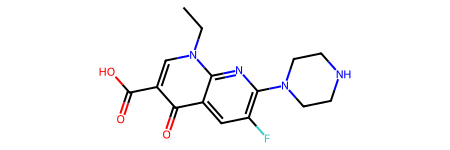

[Skip] Cluster 4: no R-groups detected (R_length=0).


10

  0%|          | 0/2 [00:00<?, ?it/s]

[15:53:42] No core matches


'2>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

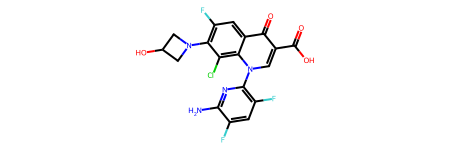

[Skip] Cluster 10: no R-groups detected (R_length=0).


13

  0%|          | 0/1 [00:00<?, ?it/s]

'1>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

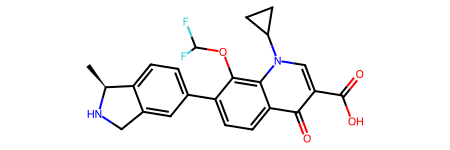

[Skip] Cluster 13: no R-groups detected (R_length=0).


15

  0%|          | 0/1 [00:00<?, ?it/s]

'1>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

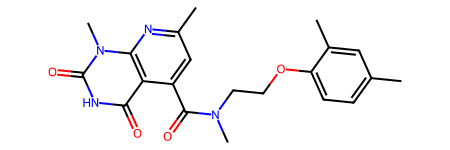

[Skip] Cluster 15: no R-groups detected (R_length=0).


16

  0%|          | 0/2 [00:00<?, ?it/s]

[15:53:42] No core matches


'2>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

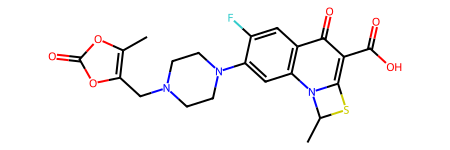

[Skip] Cluster 16: no R-groups detected (R_length=0).


17

  0%|          | 0/1 [00:00<?, ?it/s]

'1>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

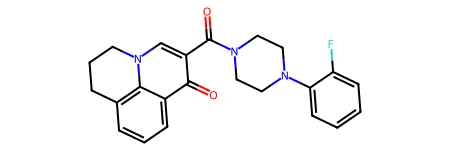

[Skip] Cluster 17: no R-groups detected (R_length=0).


18

  0%|          | 0/1 [00:00<?, ?it/s]

'1>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

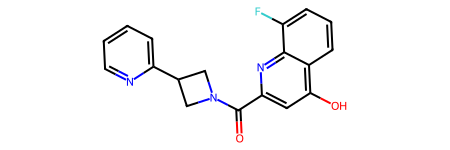

[Skip] Cluster 18: no R-groups detected (R_length=0).


11

  0%|          | 0/8 [00:00<?, ?it/s]

[15:53:43] No core matches


'8>>>>>>>7'

  0%|          | 0/7 [00:00<?, ?it/s]

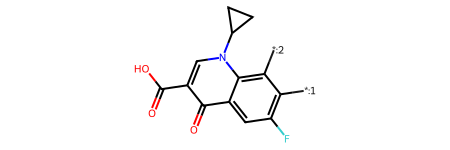

5

  0%|          | 0/3 [00:00<?, ?it/s]

[15:53:43] No core matches


'3>>>>>>>2'

  0%|          | 0/2 [00:00<?, ?it/s]

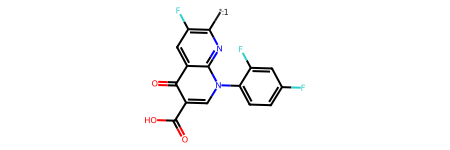

19

  0%|          | 0/1 [00:00<?, ?it/s]

'1>>>>>>>1'

  0%|          | 0/1 [00:00<?, ?it/s]

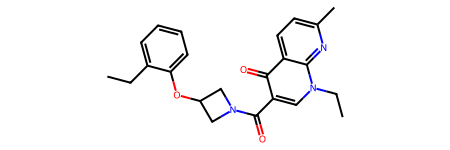

[Skip] Cluster 19: no R-groups detected (R_length=0).


7

  0%|          | 0/4 [00:00<?, ?it/s]

[15:53:43] No core matches
[15:53:43] No core matches


'4>>>>>>>2'

  0%|          | 0/2 [00:00<?, ?it/s]

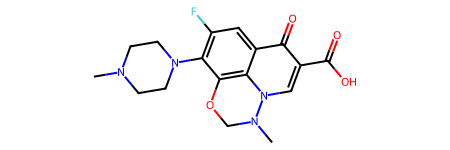

[Skip] Cluster 7: no R-groups detected (R_length=0).


In [25]:
final_output_main = pd.DataFrame()
coefficients_df = pd.DataFrame()
failed_df_main = pd.DataFrame()

for key in groupless_clusters["Cluster"].unique():
    display(key)

    #--- 1) Run individual cluster PLSR throughout groupless_clusters
    final_output, R_length, clean_scaffold_mol, preclean_scaffold, failed_df = indi_Cluster_PLSR(key, preprocessed_df, SAR_df)
    #display(final_output)

    #--- 2) collect failed PLSR objects if any
    if failed_df is not None and not failed_df.empty:
        failed_df_main = pd.concat([failed_df_main, failed_df], ignore_index=True)

    #--- 3) struc check: jump if no R-group available
    if final_output is None or final_output.empty:
        print(f"[Skip] Cluster {key}: no molecules after indi_Cluster_PLSR.")
        continue

    # at least 1 R position is required
    if (R_length is None) or (R_length < 1):
        print(f"[Skip] Cluster {key}: no R-groups detected (R_length={R_length}).")
        continue

    #--- 4) assemble feature space (column names) for one-hot encoding
    R_smiles_cols = [f"R{i}_SMILES" for i in range(1, R_length + 1)]
    categories = []
    for RG in R_smiles_cols:
        vals = final_output[RG].dropna().unique()
        categories.extend([f"{v}_{RG}" for v in vals])

    #--- 5) initialize feature matrix
    base_cols = ["Compound name", "Activity"]
    all_cols = base_cols + categories
    # create a all-0 df with #rows identical to 'final_output' and columns as 'all_cols'
    features_df = pd.DataFrame(0, index=range(len(final_output)), columns=all_cols)

    #--- 6) process IC50: log10 transform to reduce weights of extreme values
    ic50 = pd.to_numeric(final_output["IC50"], errors="coerce")
    features_df["Activity"] = np.log10(ic50)
    features_df["Compound name"] = final_output["Compound name"]

    #--- 7) vectorized one-hot encoding
    # Stack all R position cols（R1_SMILES, R2_SMILES, ... ）into long list format
    stacked = (
        final_output.melt(
            id_vars=["Compound name"],
            value_vars=R_smiles_cols,
            var_name="R_Location",
            value_name="R_SMILES"
        )
        .dropna(subset=["R_SMILES"])  
    )

    # Splice into unique names per feature
    stacked["Feature"] = stacked["R_SMILES"] + "_" + stacked["R_Location"]

    # Construct one-hot matrix
    onehot = (
        pd.get_dummies(stacked["Feature"])
        .groupby(stacked["Compound name"])
        .sum()
        .reset_index()
    )

    features_df = features_df.drop(columns=categories, errors="ignore")  
    features_df = features_df.merge(onehot, on="Compound name", how="left").fillna(0)

    base_cols = ["Compound name", "Activity"]
    features_df = features_df[base_cols + [c for c in features_df.columns if c not in base_cols]]

    #--- 8) remove rows where Activity/feature = NaN 
    features_df = features_df.dropna(subset=["Activity"]).reset_index(drop=True)

    #--- 9) Separate X (features) and y (IC50s)
    X = features_df.iloc[:, 2:]   
    y = features_df["Activity"].to_numpy()

    # remove cols where std = 0
    nunique = X.nunique(axis=0)
    X = X.loc[:, nunique > 1]
    #--- 10) at least 2 samples and 1 feature available
    if X.shape[1] < 1 or X.shape[0] < 2:
        print(f"[Skip] Cluster {key}: insufficient data for PLS (n_samples={X.shape[0]}, n_features={X.shape[1]}).")
        # fill info like scaffold back to final_output_main for easy tracking
        final_output = final_output.copy()
        final_output["Scaffold"] = preclean_scaffold
        final_output["Scaffold_Cleaned"] = clean_scaffold_mol
        final_output["Key"] = key  
        final_output["Rsq_fit"] = np.nan
        final_output["MSE"] = np.nan
        final_output_main = pd.concat([final_output_main, final_output], ignore_index=True)
        continue

    # auto adpatation n_components
    n_comp = min(2, X.shape[0] - 1, X.shape[1])
    if n_comp < 1:
        print(f"[Skip] Cluster {key}: n_components<1 after checks.")
        continue

    # fit PLS
    pls = PLSRegression(n_components=n_comp)  # by default: scale=True
    pls.fit(X, y)

    # PLS coefficients
    coefs = pls.coef_.ravel()
    feature_importance = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": coefs
    })
    feature_importance["Absolute Coefficient"] = feature_importance["Coefficient"].abs()
    feature_importance = feature_importance.sort_values(by="Absolute Coefficient", ascending=False).reset_index(drop=True)
    feature_importance["Key"] = key

    # goodness of fit
    y_pred = pls.predict(X).ravel()
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)

    # output
    final_output = final_output.copy()
    final_output["Scaffold"] = preclean_scaffold
    final_output["Scaffold_Cleaned"] = clean_scaffold_mol
    final_output["Key"] = key
    final_output["Rsq_fit"] = r2
    final_output["MSE"] = mse

    final_output_main = pd.concat([final_output_main, final_output], ignore_index=True)
    coefficients_df = pd.concat([coefficients_df, feature_importance], ignore_index=True)


split_res = coefficients_df["Feature"].astype(str).str.rsplit("_", n=2, expand=True)

while split_res.shape[1] < 3:
    split_res[f"tmp_{split_res.shape[1]}"] = np.nan
split_res.columns = ["SMILES", "R_Location", "SM_tag"]

coefficients_df = pd.concat([coefficients_df, split_res[["SMILES", "R_Location"]]], axis=1)


In [27]:
# record results from non-cluster group (ncl)
ncl_failed_df_main = failed_df_main.copy(deep=True)
ncl_coefficients_df= coefficients_df.copy(deep=True)
ncl_final_output_main= final_output_main.copy(deep=True)

In [28]:
max_key = cl_final_output_main["Key"].max()

labels_main = pd.factorize(ncl_final_output_main['Key'])[0]
ncl_final_output_main['Key'] = labels_main + int(max_key) + 1

labels_coef = pd.factorize(ncl_coefficients_df['Key'])[0]
ncl_coefficients_df['Key'] = labels_coef +int(max_key) +1


In [29]:
# for df in [cl_final_output_main, ncl_final_output_main,
#            cl_coefficients_df, ncl_coefficients_df]:
#     df["Key"] = pd.to_numeric(df["Key"], errors="coerce").astype("Int64")

# Compile the 2 sets 
all_coefficients = pd.concat([cl_coefficients_df, ncl_coefficients_df],ignore_index=True)
decomposed_df = pd.concat([cl_final_output_main, ncl_final_output_main],ignore_index=True)
#Compile Compounds that couldnt be decomposed with the cluster that was not eligible for PLSR
non_decomposed_compounds = pd.concat([cl_failed_df_main, ncl_failed_df_main],ignore_index=True)

In [31]:
cl_coefficients_df.Key.unique()

array([1, 2, 3, 5], dtype=int64)

In [30]:
all_coefficients.Key.unique()

array([1, 2, 3, 5, 6, 7], dtype=int64)

## Resort Keys for different Dfs

In [32]:
def key_sorter(df):
    sorted_keys = sorted(df["Key"].unique())
    # Create a mapping from the sorted values to a sequential range starting from 1
    mapping = {old_key: new_key for new_key, old_key in enumerate(sorted_keys, start=1)}
    # Apply the mapping to the 'Key' column
    df["Key"] = df["Key"].map(mapping)
    return(df)

In [ ]:
all_coefficients = key_sorter(all_coefficients)
decomposed_df = key_sorter(decomposed_df)

# SAR_df and plots

In [ ]:
SAR_df = pd.merge(SAR_df,decomposed_df[["Compound name","Key"]], on ="Compound name",how="left")


In [ ]:
SAR_df['Key'].unique()

array([ 2.,  5.,  4.,  7.,  6., nan,  1.,  3.])

In [ ]:
SAR_df["Key"].fillna(8, inplace=True)

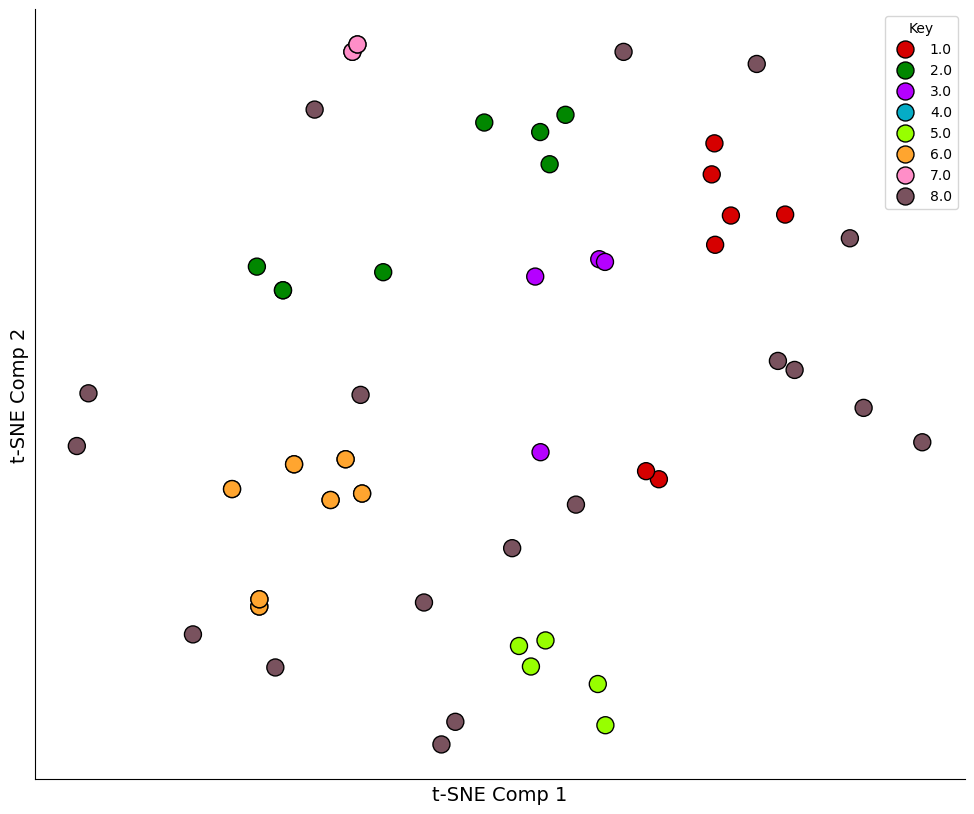

In [ ]:
# Generate synthetic data
blobs, labels = make_blobs(n_samples=1000, centers=25, center_box=(-100, 100))

# Generate a 22-color palette from colorcet's glasbey palette
custom_palette = sns.color_palette(cc.glasbey_light, n_colors=22)

plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data=SAR_df, x="tSNE_X", y="tSNE_Y", 
                     hue="Key", 
                     palette=custom_palette, 
                     edgecolor='black', 
                     s=150)
# Remove the legend
# ax.legend_.remove()
sns.despine()
# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])

# Set custom axis labels
ax.set_xlabel('t-SNE Comp 1', fontsize=14)
ax.set_ylabel('t-SNE Comp 2', fontsize=14)
# Extract color mapping from scatter plot
handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
color_dict = {label: handle.get_color() for label, handle in zip(labels, handles)}

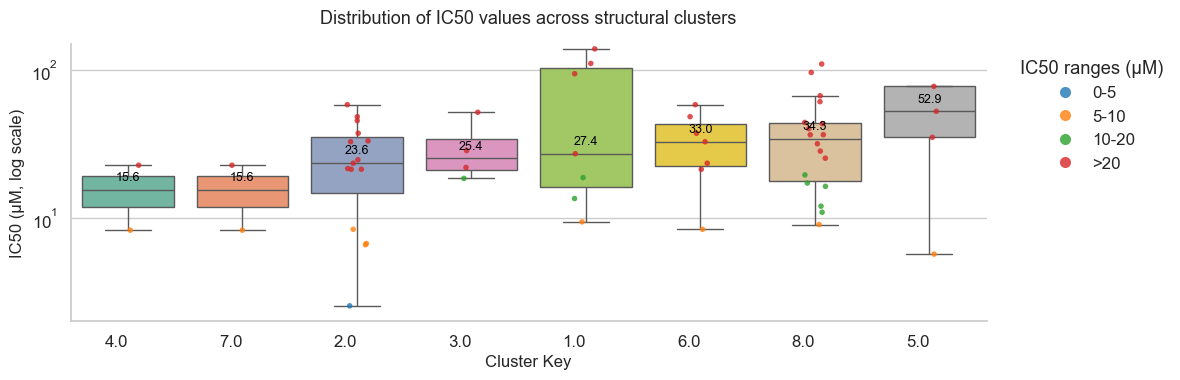

In [ ]:
# canvas setup
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(12, 4))

# order and color
median_order = SAR_df.groupby("Key")["IC50"].median().sort_values().index
ranges_order = ['0-5', '5-10', '10-20', '>20']
custom_palette = sns.color_palette("Set2", n_colors=len(median_order))

# box plot
ax = sns.boxplot(
    x="Key", y="IC50", data=SAR_df,
    palette=custom_palette, order=median_order,
    fliersize=2, linewidth=1,
    showfliers=False
)

# strip plot
sns.stripplot(
    x="Key", y="IC50", data=SAR_df,
    hue="IC50 Ranges", palette="tab10",
    order=median_order, hue_order=ranges_order,
    size=4, jitter=True, alpha=0.8, ax=ax
)

# figure legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(ranges_order)], labels[:len(ranges_order)],
          title="IC50 ranges (µM)", bbox_to_anchor=(1.02, 1),
          loc='upper left', frameon=False,
          scatterpoints=3, markerscale=2.0, handletextpad=0.6)

# median annotation
medians = SAR_df.groupby("Key")["IC50"].median()
for i, key in enumerate(median_order):
    median_val = medians[key]
    ax.text(i, median_val*1.1, f"{median_val:.1f}",
            ha='center', va='bottom', fontsize=9, color='black')

# coordinates
sns.despine()
ax.set_yscale('log')
ax.set_ylim(0, 150)
ax.set_xlabel("Cluster Key", fontsize=12)
ax.set_ylabel("IC50 (µM, log scale)", fontsize=12)
ax.set_title("Distribution of IC50 values across structural clusters", fontsize=13, pad=15)
plt.xticks(rotation=0, ha='right')

plt.tight_layout()
plt.show()


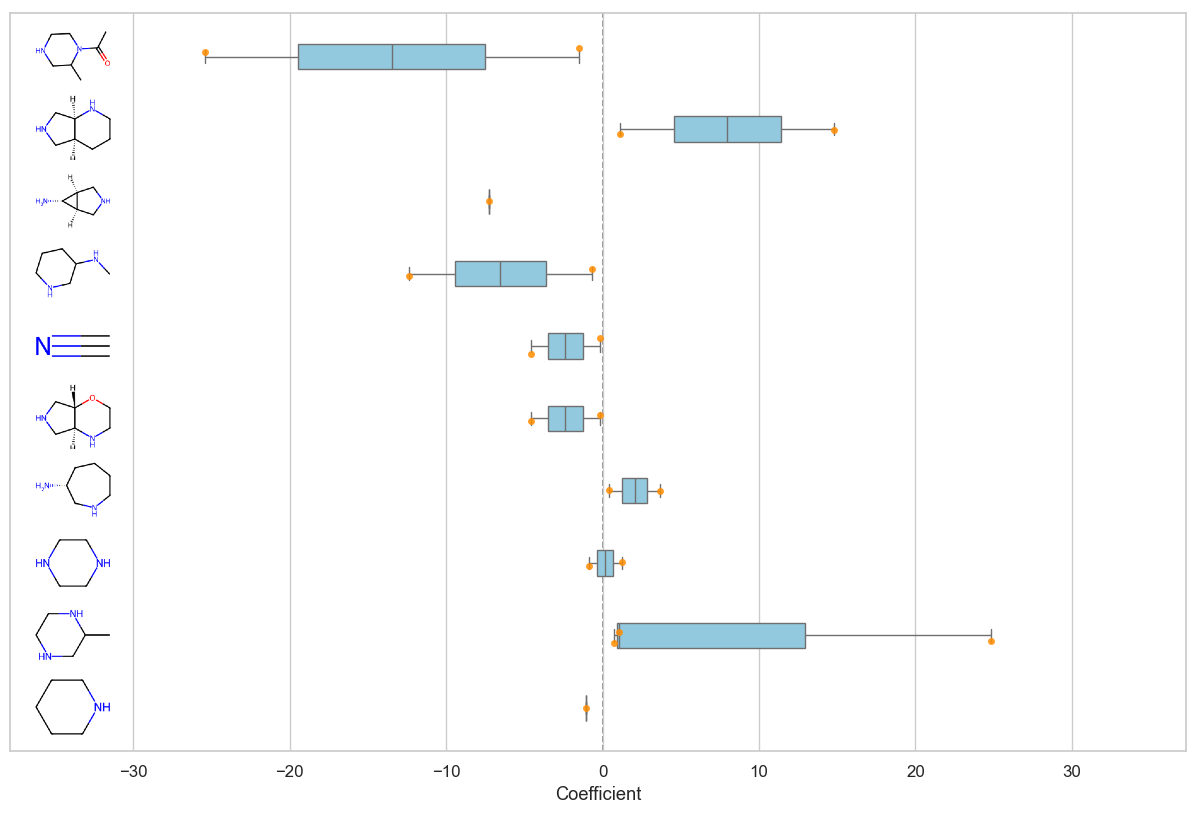

In [ ]:
coef_col = "Coefficient"
smiles_col = "SMILES"
top_n = 10
mol_size = (130, 130)   
zoom = 0.45             
group_by_abs = "median"

df = all_coefficients[[smiles_col, coef_col]].dropna(subset=[smiles_col, coef_col]).copy()

grp = df.assign(abscoef=df[coef_col].abs()).groupby(smiles_col)["abscoef"]
score = grp.median() if group_by_abs == "median" else grp.max()
order = score.sort_values(ascending=False).head(top_n).index.tolist()
plot_df = df[df[smiles_col].isin(order)].copy()

# adjust the fig height
fig_height = max(6, top_n * 0.9)  
fig, ax = plt.subplots(figsize=(14, fig_height))

# make each box more slim
sns.boxplot(
    data=plot_df, y=smiles_col, x=coef_col, order=order,
    orient='h', fliersize=0, color='skyblue',
    width=0.35,             # from 0.7 to 0.35
    linewidth=1.0,          
    ax=ax
)
sns.stripplot(
    data=plot_df, y=smiles_col, x=coef_col, order=order,
    orient='h', s=5, color="darkorange", alpha=0.85, jitter=0.12, ax=ax
)

# set middle line as x=0
ax.axvline(0, color='gray', lw=1.2, ls='--', zorder=0)

# use struc to replace SMILES
ax.set_yticklabels([""] * len(order))
ax.set_ylabel("")

# structure
xmin, xmax = ax.get_xlim()
x_pad = (xmax - xmin) * 0.18       # leave enough space to the left for struc
ax.set_xlim(xmin - x_pad, xmax + x_pad)

y_min, y_max = ax.get_ylim()
y_pad = 0.2
ax.set_ylim(y_min + 0.1, y_max - 0.1)

y_ticks = np.arange(len(order))
x0 = (xmin - x_pad) + (x_pad * 0.40)

for yi, smi in zip(y_ticks, order):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    img = Draw.MolToImage(mol, size=mol_size)
    oi = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(
        oi, (x0, yi), frameon=False,
        xycoords=('data', 'data'),
        box_alignment=(0.5, 0.5),
        #zorder=-5
    )
    ax.add_artist(ab)

plt.subplots_adjust(top=0.88, right=0.92, bottom=0.06, left=0.08)
plt.show()


,SMILES,Coefficient,Feature,mol,Key
50,[H]N1CCN(C(C)=O)C(C)C1,-25.403841,[H]N1CCN(C(C)=O)C(C)C1_R1_SMILES,,6
53,[H]N1CCCC(NC)C1,-12.382114,[H]N1CCCC(NC)C1_R1_SMILES,,6
60,[H]N1C[C@@H]2[C@@H](N)[C@@H]2C1,-7.280000,[H]N1C[C@@H]2[C@@H](N)[C@@H]2C1_R1_SMILES,,7

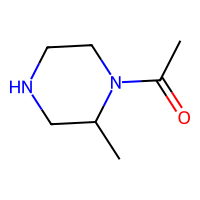
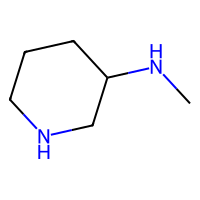
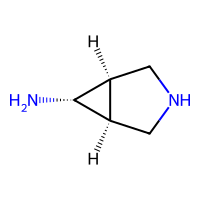

In [ ]:
all_coefficients["mol"] = all_coefficients["SMILES"].apply(Chem.MolFromSmiles)

all_coefficients.sort_values(by="Coefficient").head(3)[["SMILES", "Coefficient", "Feature", "mol", "Key"]]


,SMILES,Coefficient,Feature,mol
51,[H]N1CCNC(C)C1,24.828290,[H]N1CCNC(C)C1_R1_SMILES,
52,[H]N1C[C@@H]2CCCN[C@@H]2C1,14.818493,[H]N1C[C@@H]2CCCN[C@@H]2C1_R1_SMILES,
61,[H]N1CCC(N)C1,7.280000,[H]N1CCC(N)C1_R1_SMILES,
56,[H]N1CCCC[C@@H](N)C1,3.685424,[H]N1CCCC[C@@H](N)C1_R1_SMILES,

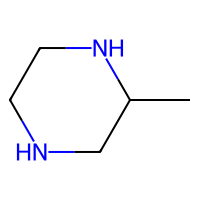
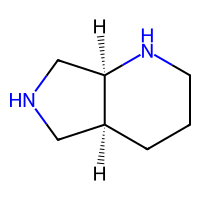
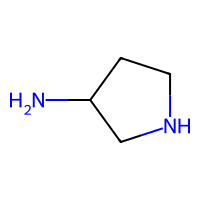
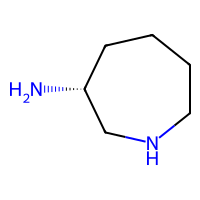

In [ ]:
all_coefficients.sort_values(by="Coefficient", ascending=False).head(4)[["SMILES", "Coefficient", "Feature", "mol"]]

# Data Export

In [ ]:
SAR_df.to_excel(r"D:\project\conda_sar\MetaSar_Code_testversion\Results\JJ\MetaSAR_RGD_results/LR_SAR_final_Fib.xlsx") #Contains decomposed df in it
decomposed_df.to_excel(r"D:\project\conda_sar\MetaSar_Code_testversion\Results\JJ\MetaSAR_RGD_results/LR_decomposed_df_Fib.xlsx")
all_coefficients.to_excel(r"D:\project\conda_sar\MetaSar_Code_testversion\Results\JJ\MetaSAR_RGD_results/LR_results_Fib.xlsx")